# **Importing Packages**

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from tqdm import tqdm
from torchvision import models
import cv2


# **Defining Generator**

I tried using "from fulfills import Generator", but it was weirdly saying that fulfills does not exist. So I copy-pasted the architecture.

In [58]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generator_model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2),             
            nn.Conv2d(512, 4000, 1),
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(),            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),             
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  # Adjusted for output size
            nn.Tanh()
        )

    def forward(self, x):
        x = self.generator_model(x)
        return x

# **Loading Weights and Biases from trained Model**

These are the Weights and Biases after I trained the model on Google-Street-View

In [59]:

generator = Generator()
generator.load_state_dict(torch.load("generator.pth"))
generator.eval()



Generator(
  (generator_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 4000,

# **Testing it on Video**

The video is footage from Eve's dashcam meant for the Oil Painting Task

In [60]:
import cv2
import torch
import numpy as np

def apply_constant_mask(frame):
    h, w, _ = frame.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    mask_h, mask_w = h // 4, w // 4
    mask[int(h/2 - mask_h/2):int(h/2 + mask_h/2), int(w/2 - mask_w/2):int(w/2 + mask_w/2)] = 255
    frame[mask == 255] = (0, 0, 0)  
    return frame, cv2.resize(mask, (128, 128))  

def resize_frame(frame):
    return cv2.resize(frame, (128, 128))

def upscale_frame(frame):
    return cv2.resize(frame, (512, 512))

video = cv2.VideoCapture('sp.mp4') 

fps = video.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, fps, (512, 512)) 

#Videos are not getting saved and keep on showing up as invalid format. Fix later if time.

while True:
    ret, frame = video.read()
    if not ret:
        break

    resized_frame = resize_frame(frame)

    masked_frame, mask = apply_constant_mask(resized_frame)

    input_tensor = torch.tensor(masked_frame / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
#Error was initially done because I did not convert them to tensors. Tried to fix but did not work so I used ChatGPT.
    with torch.no_grad():
        inpainted_frame = generator(input_tensor).squeeze(0).permute(1, 2, 0).cpu().numpy() * 255.0
        inpainted_frame = inpainted_frame.astype(np.uint8)

    repaired_frame = masked_frame.copy()
    repaired_frame[repaired_frame == 0] = inpainted_frame[repaired_frame == 0]

    resized_repaired_frame = upscale_frame(repaired_frame)

    resized_masked_frame = upscale_frame(masked_frame)

    display_frame = np.concatenate((resized_repaired_frame, resized_masked_frame), axis=1)

    output_video.write(display_frame)

    cv2.imshow('Repaired and Masked Video', display_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
output_video.release()
cv2.destroyAllWindows()








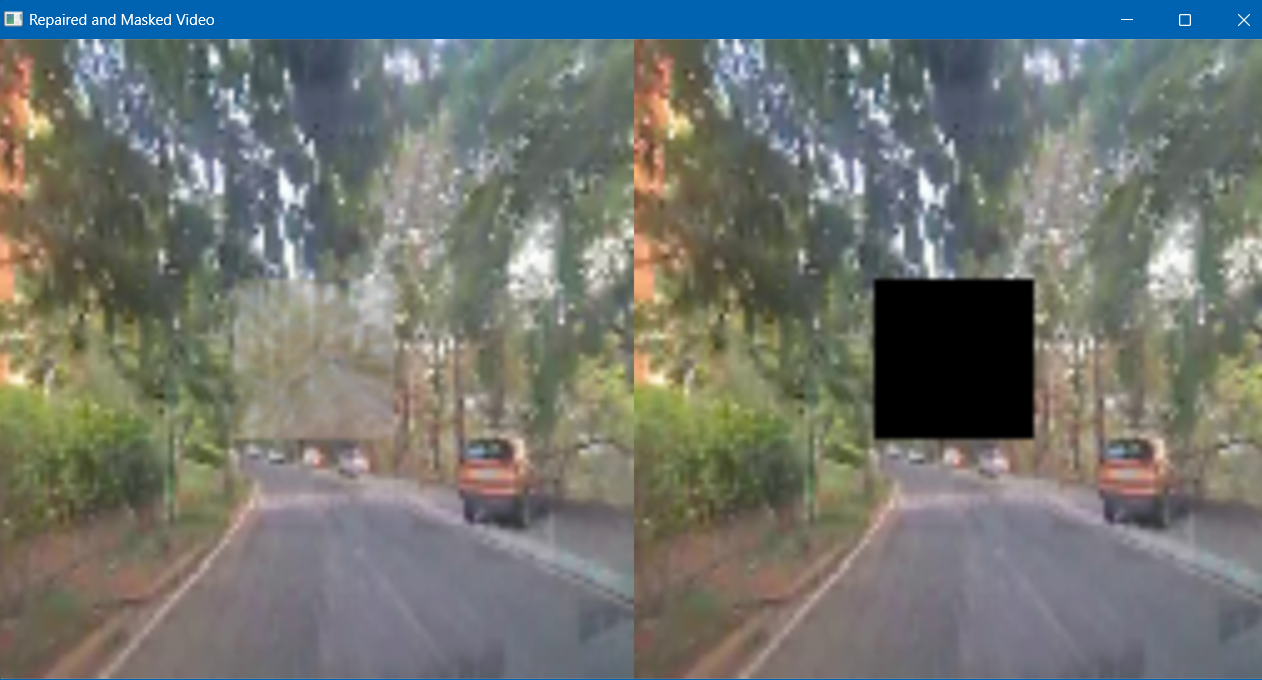

Kind of Decent...Not Perfect but passable

Similar Results on the drone video from Summer Slam. Was able to inpaint grass,mountains and sky. Did not recognize the river. I think it is because the training dataset really did not have any water bodies except for one image of a lake I found by chance